**Remotely Sensed Spectral Radiance**  
**Author: Ramesh Bhatta, CIS, RIT**

In [20]:
## Importing Packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate

**Task 1: Ground-Leaving Radiance**

In [22]:
## Define class for functions

class upwelled_radiance:
    def __init__(self, lamb1, lamb2):
        self.reflectance = 0.1
        self.sun_temp = 5800
        self.surf_temp = 300
        self.zenith_angle = [0, np.pi/6, np.pi/3]
        self.lamb1 = lamb1
        self.lamb2 = lamb2
        self.lamb = np.linspace(self.lamb1, self.lamb2, 1000)
        self.conversion_factor = 1e-4
    
    def black_body_sun(self):
        h = 6.626e-34
        c = 3e8
        k = 1.38e-23
        return ((2*h*c**2)/self.lamb**5)*(1/(np.exp(h*c/(self.lamb*k*self.sun_temp))-1))
    
    def black_body_surface(self):
        h = 6.626e-34
        c = 3e8
        k = 1.38e-23
        return ((2*h*c**2)/self.lamb**5)*(1/(np.exp(h*c/(self.lamb*k*self.surf_temp))-1))
    
    def reflected_rad(self, zenith_angle):
        r_sun = 695000 #km
        r_earth_sun = 149.68e6 #km
        sq_dist_ratio = (r_sun/r_earth_sun)**2
        sun = self.black_body_sun()
        return self.reflectance*sun*np.cos(zenith_angle)*sq_dist_ratio
    
    def emitted_rad(self):
        return self.black_body_surface() * (1 - self.reflectance)
    
    def plot_graph(self):
        
        fig = plt.figure(figsize=(15, 7))
        plt.plot(self.lamb, self.conversion_factor * self.reflected_rad(self.zenith_angle[0]), label = 'Zenith Angle = 0')
        plt.plot(self.lamb,self.conversion_factor * self.reflected_rad(self.zenith_angle[1]), label = 'Zenith Angle = 30')
        plt.plot(self.lamb, self.conversion_factor * self.reflected_rad(self.zenith_angle[2]), label = 'Zenith Angle = 60')
        plt.plot(self.lamb,self.conversion_factor * self.emitted_rad(), label = 'Self Emitted Radiance at 300k')
        plt.legend()
        plt.title('Reflected Radiance at different Zenith Angles and Self Emitted Radiance')
        plt.xlabel('Wavelength (um)')
        plt.ylabel('Radiance (uW/cm^2/sr/um)')  
        plt.tight_layout()
        plt.show()     

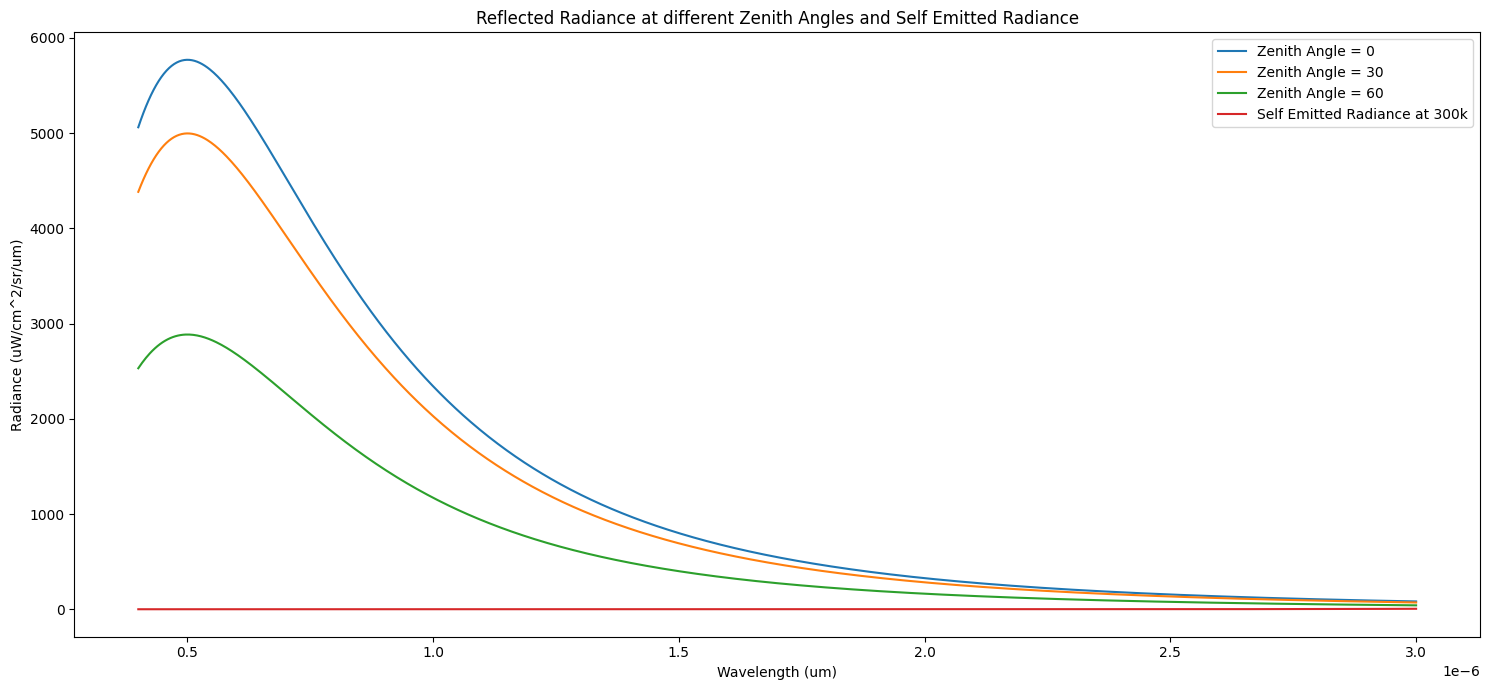

In [23]:
## Plotting the Reflected and Emitted radiance at different zenith angles for VNIR/SWIR

upwelled_radiance(0.4e-6,3e-6).plot_graph()

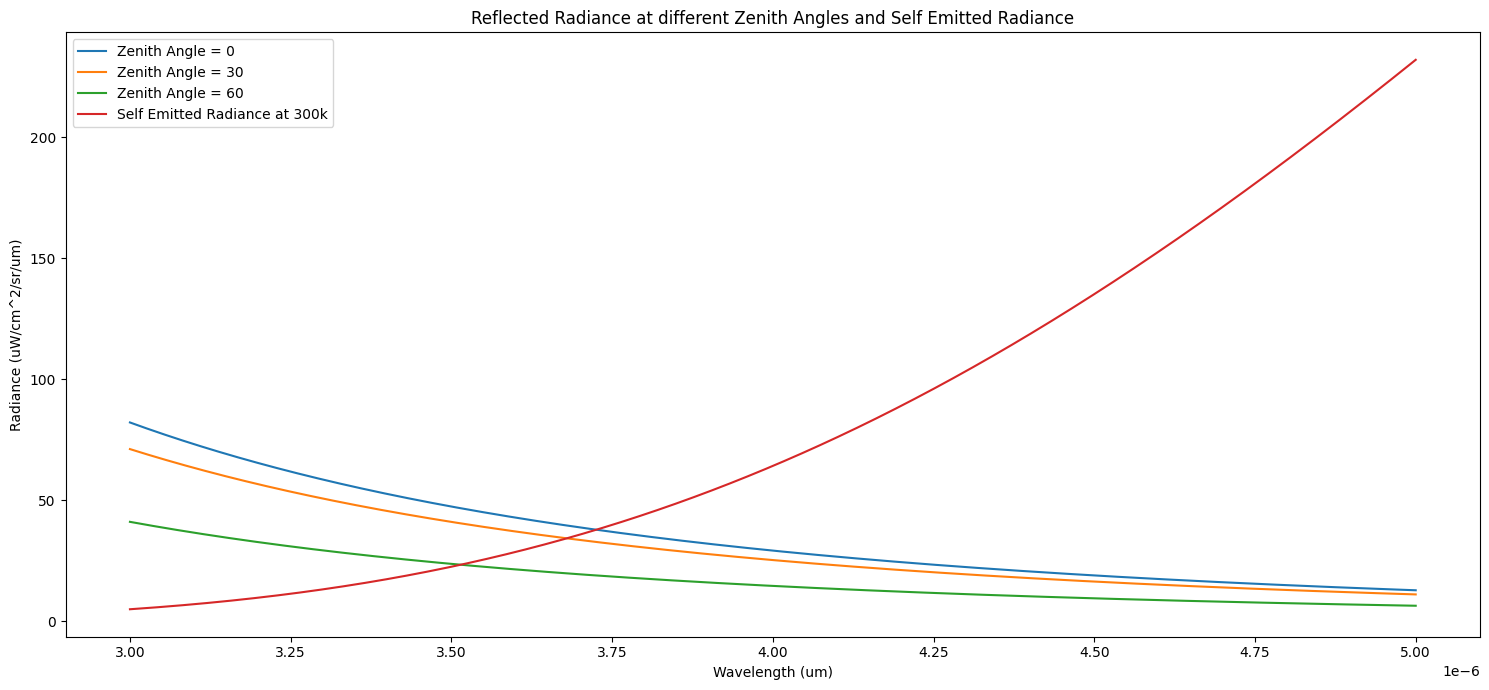

In [24]:
## Plotting the Reflected and Emitted radiance at different zenith angles for MWIR

upwelled_radiance(3e-6,5e-6).plot_graph()

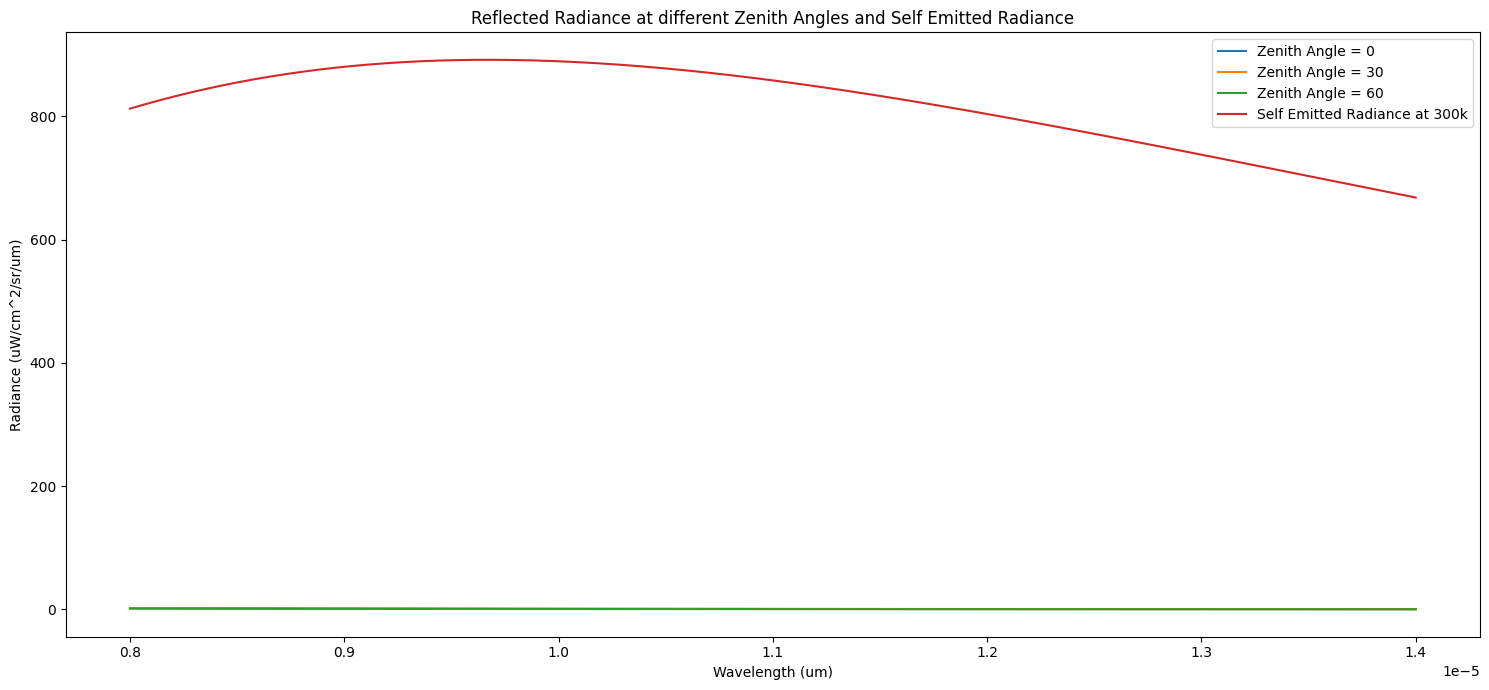

In [25]:
## Plotting the Reflected and Emitted radiance at different zenith angles for LWIR

upwelled_radiance(8e-6,14e-6).plot_graph()

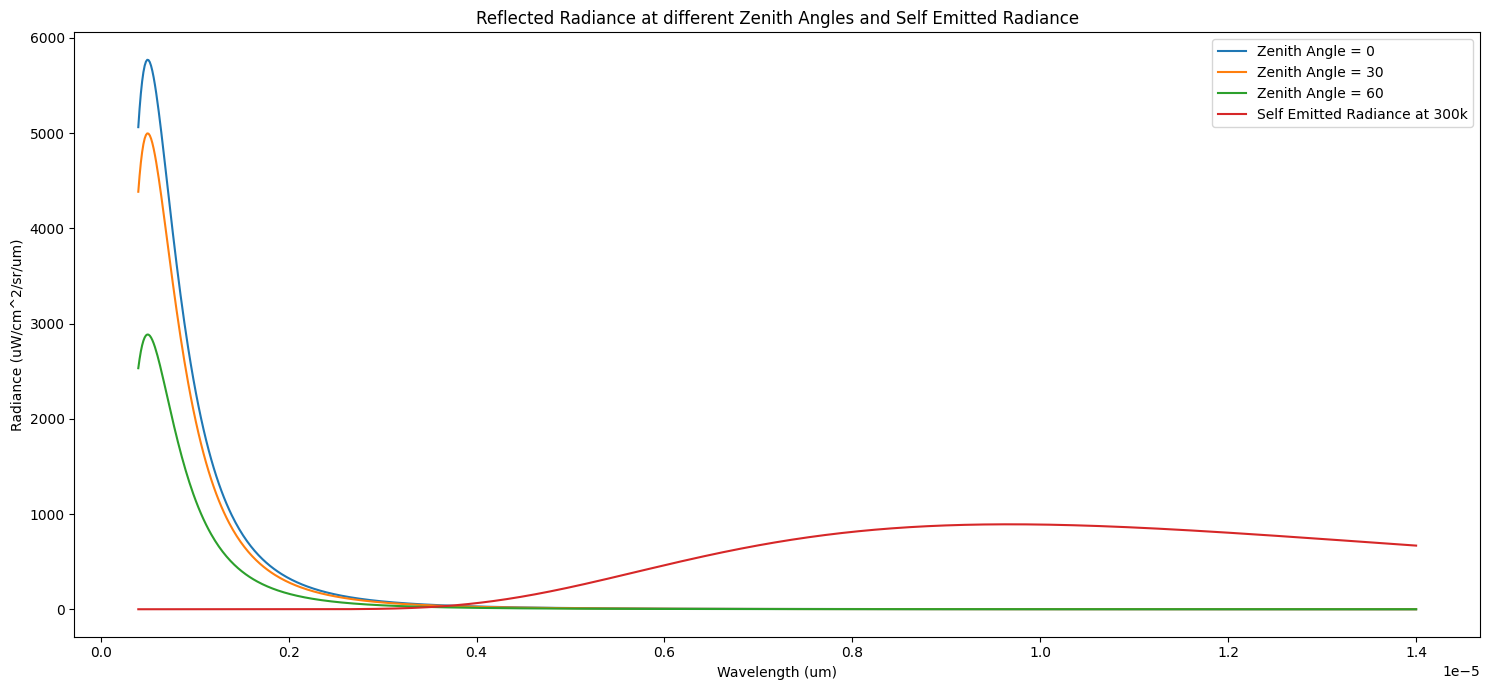

In [26]:
## Overall Wavelength range Plot:0.4 microns to 14 microns
upwelled_radiance(0.4e-6,14e-6).plot_graph()


**Task 2: Camouflage Detection**

In [8]:
## Importing the Data

tree_camouflage_ref = pd.read_excel('Tree and Camouflage Reflectance.xls')
VNIR_SWIR_atmospherics = pd.read_excel('VNIR SWIR Atmospherics.xls')

In [9]:
## Define The Spectral Discrimination Class

class spectral_discrimination:
    
    def __init__(self):
        self.zenith_angle = 17.6*0.0174532925    #conversion to radiance
    
    def upscale_data(self, tree_camouflage_ref, VNIR_SWIR_atmospherics):      
        self.data_1 = tree_camouflage_ref
        self.data_2 = VNIR_SWIR_atmospherics
        
        ## Fitting using linear-interpolation
        
        x_earlier_wavelength = self.data_1['Wavelength (um)']
        x_new_wavelength = self.data_2['Wavelength']
        
        new_conifer_canopy = np.interp(x_new_wavelength, x_earlier_wavelength, self.data_1['Coniferous Canopy'] )
        new_camouflage = np.interp(x_new_wavelength, x_earlier_wavelength, self.data_1['Camouflage'])
        
        upscaled_tree_cmf_data = pd.DataFrame()
        upscaled_tree_cmf_data['wavelength'] = x_new_wavelength
        upscaled_tree_cmf_data['coniferous_canopy'] = new_conifer_canopy
        upscaled_tree_cmf_data['camouflage'] = new_camouflage
        
        return upscaled_tree_cmf_data
    
    def plot_data(self, dataframe):
        self.df = dataframe
        fig = plt.figure(figsize=(15, 7))
        plt.plot(self.df.iloc[:,0], self.df.iloc[:,1], label= 'coniferous_canopy')
        plt.plot(self.df.iloc[:,0], self.df.iloc[:,2], label= 'camouflage')
        plt.title('Plot For {} and {} Reflectance'.format(self.df.columns[1], self.df.columns[2]))
        plt.xlabel('Wavelength (microns)')
        plt.ylabel('reflectance')
        plt.tight_layout()
        plt.grid() 
        plt.legend()
        plt.show()
        
    def obs_spectral_rad(self, vnir_swir_atms, reflectance):
        self.transmission = vnir_swir_atms.iloc[:,3]
        self.path_radiance = vnir_swir_atms.iloc[:,4]
        self.direct_solar_irradiance = vnir_swir_atms.iloc[:,1]
        self.indirect_downwell_radiance = vnir_swir_atms.iloc[:,2]
        self.wavelength = vnir_swir_atms.iloc[:,0]
        self.reflectance = reflectance
        spectral_rad = ((self.transmission/np.pi) * self.reflectance * ((self.direct_solar_irradiance * np.cos(self.zenith_angle))+(np.pi * self.indirect_downwell_radiance))) + self.path_radiance
        
        return spectral_rad
                 

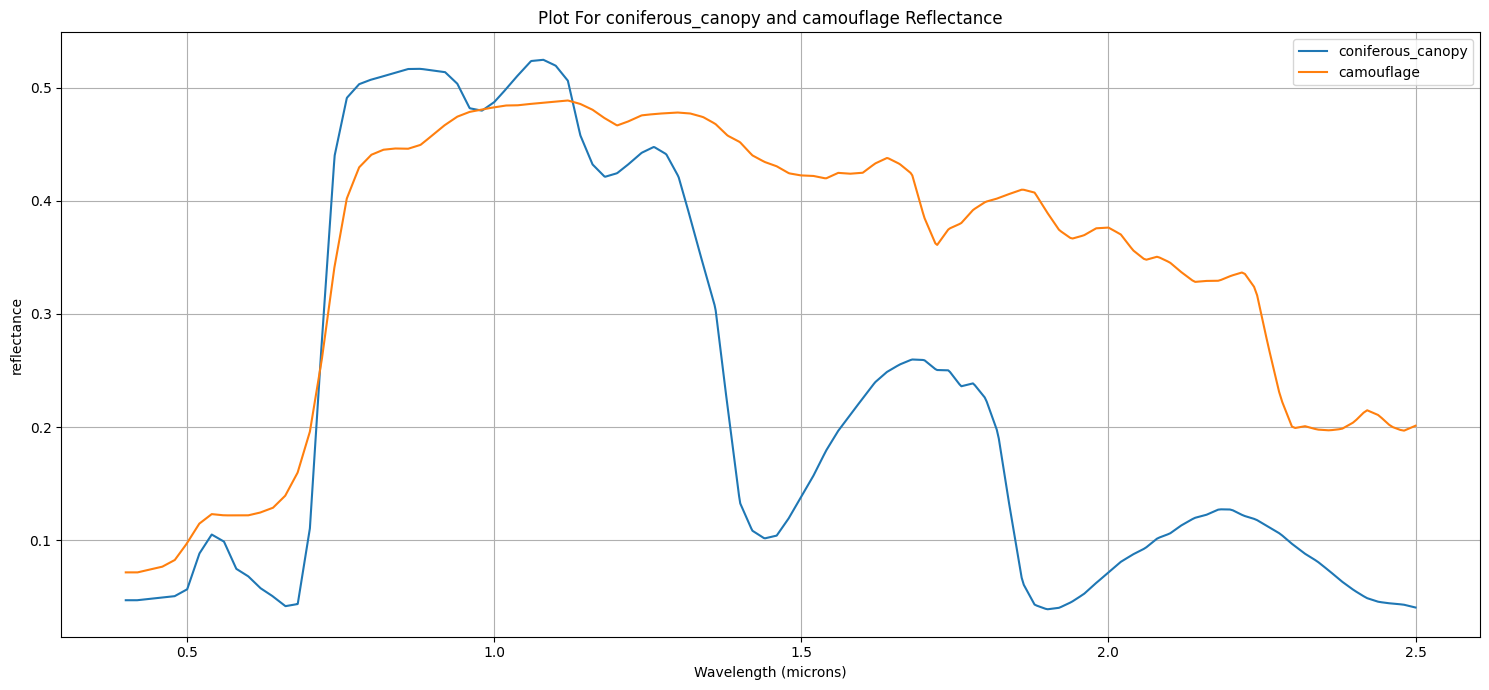

In [10]:
## Upscaling the Tree Camouflage Data to match VNIR-SWIR atmospheric wavelengths spacing

upsampled_data = spectral_discrimination().upscale_data(tree_camouflage_ref, VNIR_SWIR_atmospherics)
spectral_discrimination().plot_data(upsampled_data)


In [11]:

## Calculating Camoflauge/target and Background Spectral Radiances and Adding to upsampled Dataframe

upsampled_data['camouflage_radiance'] = spectral_discrimination().obs_spectral_rad(VNIR_SWIR_atmospherics, upsampled_data.iloc[:,2])
upsampled_data['background_radiance'] = spectral_discrimination().obs_spectral_rad(VNIR_SWIR_atmospherics, upsampled_data.iloc[:,1])
upsampled_data['difference_radiance'] = upsampled_data.iloc[:,3] - upsampled_data.iloc[:,4]

## Final Calculated Data-Frame Looks Like:

print('\033[1m\033[4m' + 'FINAL DATAFRAME OF ALL CALCULATED VALUES: ' + '\033[0m')
upsampled_data

FINAL DATAFRAME OF ALL CALCULATED VALUES: 


,wavelength,coniferous_canopy,camouflage,camouflage_radiance,background_radiance,difference_radiance
0,2.500000,0.040380,0.201162,0.656274,0.509691,0.146583
1,2.493766,0.041197,0.199712,0.402700,0.375872,0.026828
2,2.487562,0.042009,0.198268,0.490510,0.421568,0.068942
3,2.481390,0.042818,0.196832,1.330104,0.781128,0.548976
4,2.475248,0.043221,0.197469,5.553209,2.222097,3.331112
...,...,...,...,...,...,...
2096,0.400641,0.046820,0.071456,16852.841096,16507.012628,345.828468
2097,0.400481,0.046820,0.071456,24853.303754,24344.069264,509.234490
2098,0.400320,0.046820,0.071456,24139.317601,23645.405217,493.912384
2099,0.400160,0.046820,0.071456,22134.226121,21682.047900,452.178221


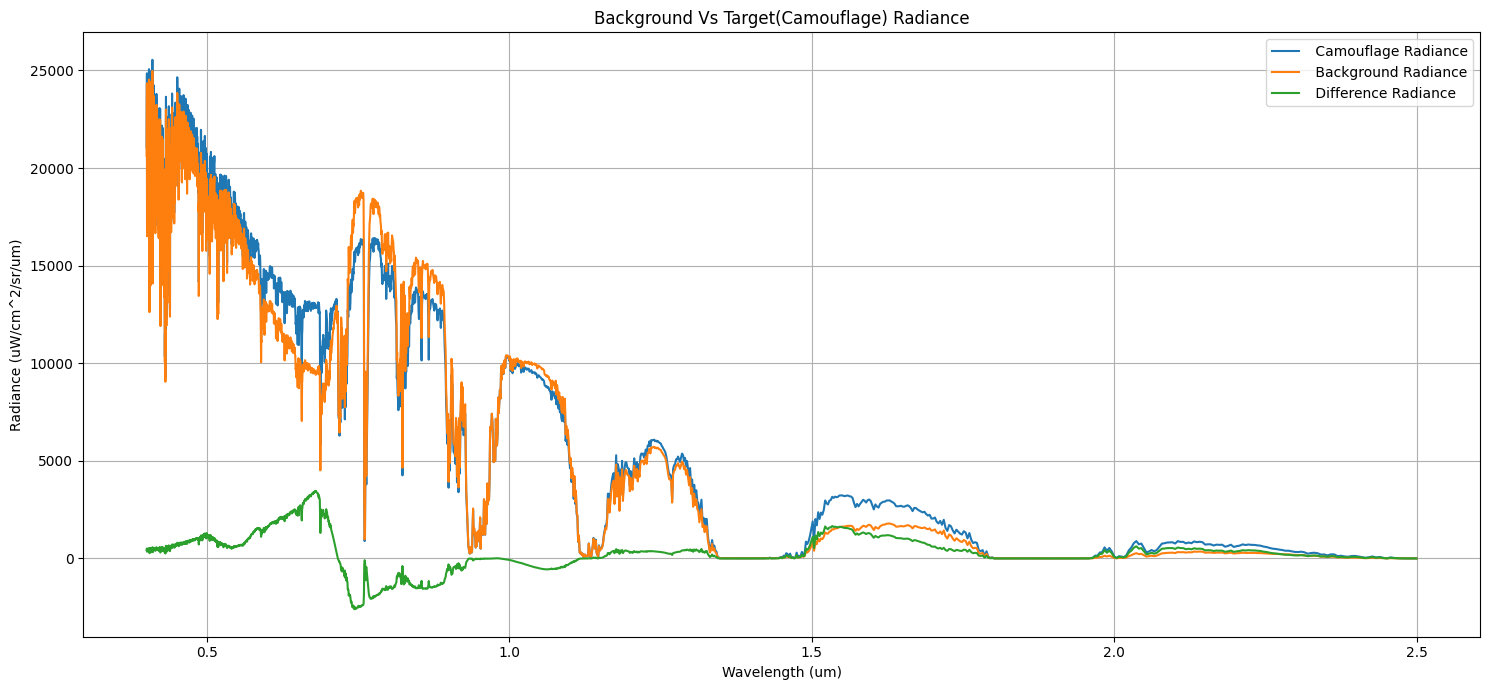

In [12]:
## Plotting All the Radiances vs Wavelength

fig = plt.figure(figsize=(15, 7))
plt.plot(upsampled_data.iloc[:,0], upsampled_data.iloc[:,3], label = ' Camouflage Radiance')
plt.plot(upsampled_data.iloc[:,0], upsampled_data.iloc[:,4], label = ' Background Radiance')
plt.plot(upsampled_data.iloc[:,0], upsampled_data.iloc[:,5], label = ' Difference Radiance')
plt.title('Background Vs Target(Camouflage) Radiance')
plt.xlabel('Wavelength (um)')
plt.ylabel('Radiance (uW/cm^2/sr/um)') 
plt.legend() 
plt.grid()
plt.tight_layout()
plt.show()

**The Spectral Features:**  
As we can see clearly from above plots, there are mainly two regions where we would like to look in order to differentiate the Coniferous Forest and Camouflage target. The first major region is from around
0.5 microns to 0.8 microns (around 0.7 microns seems to be the best), where we see higher contrast between background and target radiances. Also there is a minor region from around 1.5 microns to 1.8 microns where there is some visible contrast in radiances. In all the other wavelength regions it is difficult to actually notice the difference in Radiance.

**Task 3: Propane Gas Discrimination**


In [27]:
## Importing The Given Data

propane_Absorbance = pd.read_excel('Propane Absorbance.xls')
MWIR_LWIR_Atmospherics = pd.read_excel('MWIR LWIR Atmospherics.xls')
ground_temperture = 300 #Kelvin
plume_temperature = [295, 300, 305] #Kelvin
conc = 5 #ppm 
thickness = 1 #m

In [28]:
## Sorting and Selecting only the required Wavelengths- LWIR

propane_Absorbance = propane_Absorbance[::-1].sort_values(by=['Wavelength (um)']).reset_index(drop=True)
propane_Absorbance = propane_Absorbance[(propane_Absorbance.iloc[:,0] >= 8) & (propane_Absorbance.iloc[:,0] <= 12)]

MWIR_LWIR_Atmospherics = MWIR_LWIR_Atmospherics[::-1].sort_values(by=['Wavelength']).reset_index(drop=True)
MWIR_LWIR_atmospherics =  MWIR_LWIR_Atmospherics[(MWIR_LWIR_Atmospherics['Wavelength'] >= 8) & (MWIR_LWIR_Atmospherics['Wavelength'] <= 12)]

In [29]:
## Interpolating the Propane Absorbance Data to match MWIR-LWIR atmospheric wavelengths spacing(Upsampling)

x_earlier_wavelength = propane_Absorbance['Wavelength (um)']
x_new_wavelength = MWIR_LWIR_atmospherics['Wavelength']

new_absorbance = np.interp(x_new_wavelength, x_earlier_wavelength, propane_Absorbance.iloc[:,1])

## Update Propane Absorbance Dataframe

propane_absorbance = pd.DataFrame()
propane_absorbance['wavelength'] = x_new_wavelength
propane_absorbance['absorbance'] = new_absorbance

In [30]:
## Calculating the plume transmission and emittance and putting it in same dataframe

propane_absorbance['transmission'] = np.exp(-conc * thickness * propane_absorbance.iloc[:,1])
propane_absorbance['emittance'] = 1 - propane_absorbance.iloc[:,2]

In [31]:
## Calculating the Observed Plume Spectral Radiance
## Blackbody Radiance at Particular temperature

def black_body(temp):         
        lamb = propane_absorbance.iloc[:,0] * (10 ** (-6))      
        h = 6.626e-34
        c = 3e8
        k = 1.38e-23
        cf = 1e-4
        return cf * ((2*h*c**2)/lamb**5)*(1/(np.exp(h*c/(lamb*k*temp))-1))

## Observed Plume Spectral Radiance
   
propane_absorbance['plume_radiance_295k'] = (black_body(ground_temperture) * MWIR_LWIR_atmospherics.iloc[:,2] * propane_absorbance.iloc[:,2]) + (black_body(plume_temperature[0]) * propane_absorbance.iloc[:,3] * MWIR_LWIR_atmospherics.iloc[:,2]) + MWIR_LWIR_atmospherics.iloc[:,3]
propane_absorbance['plume_radiance_300k'] = (black_body(ground_temperture) * MWIR_LWIR_atmospherics.iloc[:,2] * propane_absorbance.iloc[:,2]) + (black_body(plume_temperature[1]) * propane_absorbance.iloc[:,3] * MWIR_LWIR_atmospherics.iloc[:,2]) + MWIR_LWIR_atmospherics.iloc[:,3]
propane_absorbance['plume_radiance_305k'] = (black_body(ground_temperture) * MWIR_LWIR_atmospherics.iloc[:,2] * propane_absorbance.iloc[:,2]) + (black_body(plume_temperature[2]) * propane_absorbance.iloc[:,3] * MWIR_LWIR_atmospherics.iloc[:,2]) + MWIR_LWIR_atmospherics.iloc[:,3]

## Observed Background/Grass Spectral Radiance

propane_absorbance['ground_radiance_300k'] = (black_body(ground_temperture) * MWIR_LWIR_atmospherics.iloc[:,2]) + MWIR_LWIR_atmospherics.iloc[:,3]

## Difference Spectral Radiance

propane_absorbance['difference_radiance_295k'] = propane_absorbance.iloc[:,4] - propane_absorbance.iloc[:,7] ## ground and 295k plume
propane_absorbance['difference_radiance_300k'] = propane_absorbance.iloc[:,5] - propane_absorbance.iloc[:,7] ## ground and 300k plume
propane_absorbance['difference_radiance_305k'] = propane_absorbance.iloc[:,6] - propane_absorbance.iloc[:,7] ## ground and 305k plume

## Final Calculated Data-Frame Looks Like:
print('\033[1m\033[4m' + 'FINAL DATAFRAME OF ALL CALCULATED VALUES: ' + '\033[0m')
propane_absorbance

FINAL DATAFRAME OF ALL CALCULATED VALUES: 


,wavelength,absorbance,transmission,emittance,plume_radiance_295k,plume_radiance_300k,plume_radiance_305k,ground_radiance_300k,difference_radiance_295k,difference_radiance_300k,difference_radiance_305k
688,8.012821,0.494150,0.084522,0.915478,613.069880,635.131283,658.722247,635.131283,-22.061403,0.000000e+00,23.590964
689,8.038585,0.475891,0.092601,0.907399,553.691399,564.885660,576.852308,564.885660,-11.194261,0.000000e+00,11.966648
690,8.064516,0.400476,0.135014,0.864986,664.192109,686.230949,709.783090,686.230949,-22.038839,0.000000e+00,23.552141
691,8.090615,0.301663,0.221283,0.778717,708.185634,739.452550,772.856004,739.452550,-31.266916,0.000000e+00,33.403454
692,8.116883,0.205366,0.358141,0.641859,790.259870,826.646228,865.506838,826.646228,-36.386358,0.000000e+00,38.860609
...,...,...,...,...,...,...,...,...,...,...,...
787,11.737089,0.136197,0.506119,0.493881,769.378496,778.585627,788.141423,778.585627,-9.207132,0.000000e+00,9.555796
788,11.792453,0.143667,0.487563,0.512437,820.298478,836.284610,852.871385,836.284610,-15.986132,0.000000e+00,16.586775
789,11.848341,0.134239,0.511098,0.488902,827.583600,843.831503,860.685082,843.831503,-16.247903,1.136868e-13,16.853579
790,11.904762,0.119953,0.548941,0.451059,799.833623,811.634855,823.872522,811.634855,-11.801232,0.000000e+00,12.237667


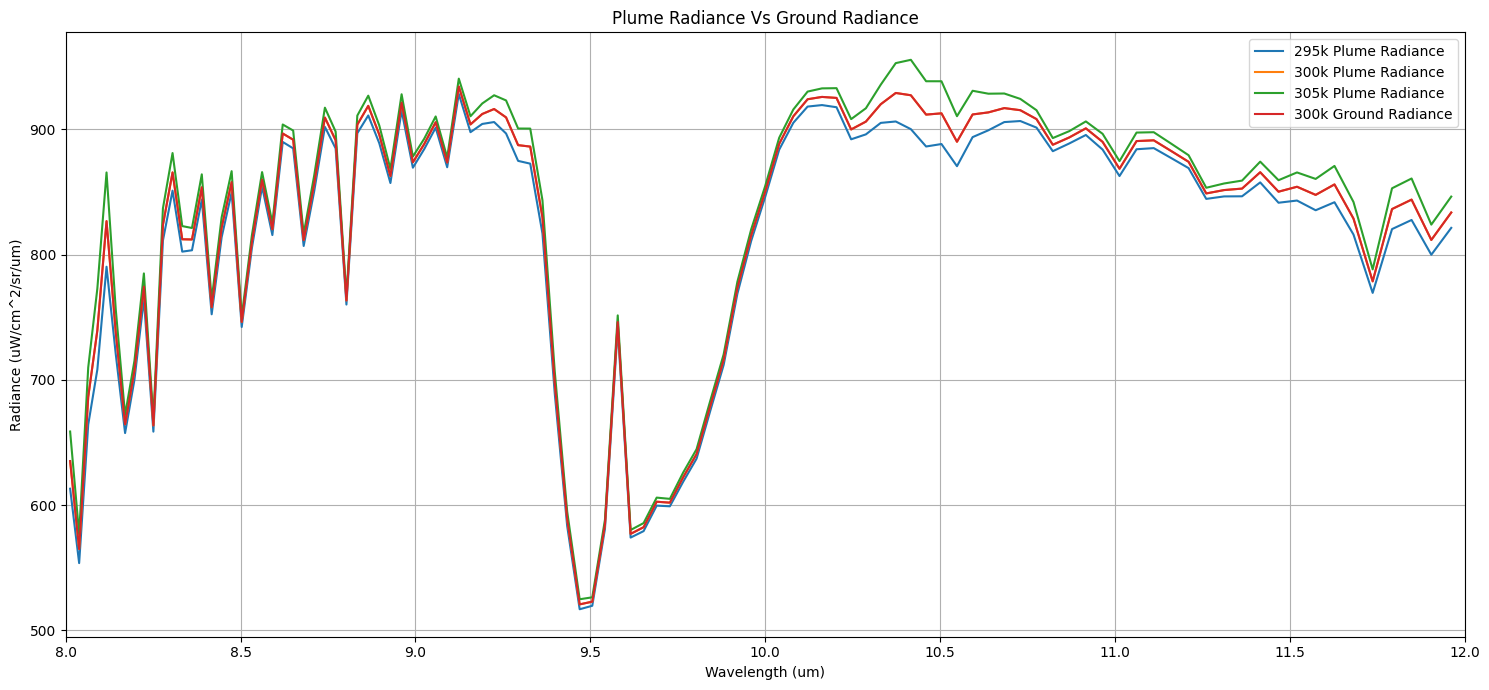

In [32]:
## Plotting the required graphs

fig = plt.figure(figsize=(15, 7))
plt.plot(propane_absorbance.iloc[:,0], propane_absorbance.iloc[:,4], label = '295k Plume Radiance')
plt.plot(propane_absorbance.iloc[:,0], propane_absorbance.iloc[:,5], label = '300k Plume Radiance')
plt.plot(propane_absorbance.iloc[:,0], propane_absorbance.iloc[:,6], label = '305k Plume Radiance')
plt.plot(propane_absorbance.iloc[:,0], propane_absorbance.iloc[:,7], label = '300k Ground Radiance')
plt.title('Plume Radiance Vs Ground Radiance')
plt.xlabel('Wavelength (um)')
plt.ylabel('Radiance (uW/cm^2/sr/um)')
plt.xlim(8,12) # LWIR
plt.legend()
plt.grid()
plt.tight_layout()

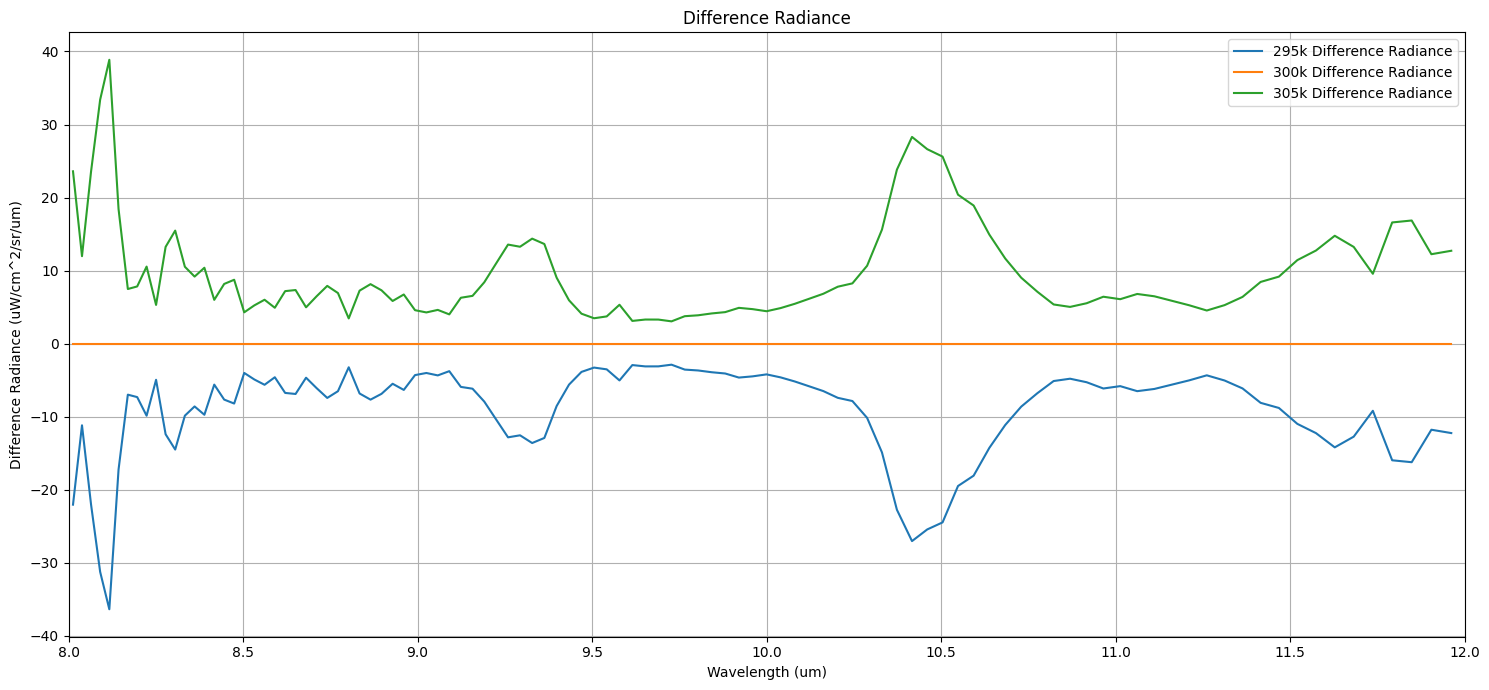

In [33]:
## Difference Plot

fig = plt.figure(figsize=(15, 7))
plt.plot(propane_absorbance.iloc[:,0], propane_absorbance.iloc[:,8], label = '295k Difference Radiance')
plt.plot(propane_absorbance.iloc[:,0], propane_absorbance.iloc[:,9], label = '300k Difference Radiance')
plt.plot(propane_absorbance.iloc[:,0], propane_absorbance.iloc[:,10], label = '305k Difference Radiance')
plt.title('Difference Radiance')
plt.xlabel('Wavelength (um)')
plt.ylabel('Difference Radiance (uW/cm^2/sr/um)')
plt.xlim(8,12) # LWIR
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

**The Spectral Features**

As we can see from the spectral radiance difference plot, when there is difference in temperature between the plume and ground surface we notice some contrast in the measured radiance specialy in regions
around (8-8.5) microns, (10-11) microns and somewhat in (9-9.5) microns. We can see that there should be a temperature difference between ground surface and plume to detect the plumes. No temperature difference present zero contrast and no detection as shown by 300k difference radiance plot. 
